In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [7]:
zoo = pd.read_csv('data/zoo.csv')
class_label = pd.read_csv('data/class.csv')

- First, we see that fot not every animal class we have the same number of rows. In this dataset, the less frequent type of animal are the amphibians, and the most common the mammals. This makes sense for a zoo, which contains a variety of different animals.

In [8]:
class_label

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


- As it is stated on the source page of the dataset, the zoo dataframe contains information about characteristics of each animal. Mostly of the features are of boolean type, except for _legs_ which is a numerical column. This is the dataset we will use to analyze information and to develop our model.

In [11]:
zoo

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


# Analysis

## EDA

- First, let's see the presence of each of the variables in the dataset.
- Since the majority of these features are boolean (legs is numerical, and class_type is the label to verify our results), computing the mean is equivalent to the percentage of rows that are true for that feature.

In [17]:
zoo.describe().loc['mean']

hair          0.425743
feathers      0.198020
eggs          0.584158
milk          0.405941
airborne      0.237624
aquatic       0.356436
predator      0.554455
toothed       0.603960
backbone      0.821782
breathes      0.792079
venomous      0.079208
fins          0.168317
legs          2.841584
tail          0.742574
domestic      0.128713
catsize       0.435644
class_type    2.831683
Name: mean, dtype: float64

,index,mean
0,hair,0.425743
1,feathers,0.198020
2,eggs,0.584158
3,milk,0.405941
4,airborne,0.237624
5,aquatic,0.356436
6,predator,0.554455
7,toothed,0.603960
8,backbone,0.821782
9,breathes,0.792079


In [56]:
zoo

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [65]:
non_boolean_features = ['legs', 'class_type']
numerical_features = ['legs']
animal_names_column = ['animal_name']


col_set = set(list(zoo.columns))
boolean_features = col_set-set(non_boolean_features+animal_names_column)
boolean_features_w_class = col_set - set(numerical_features+animal_names_column)

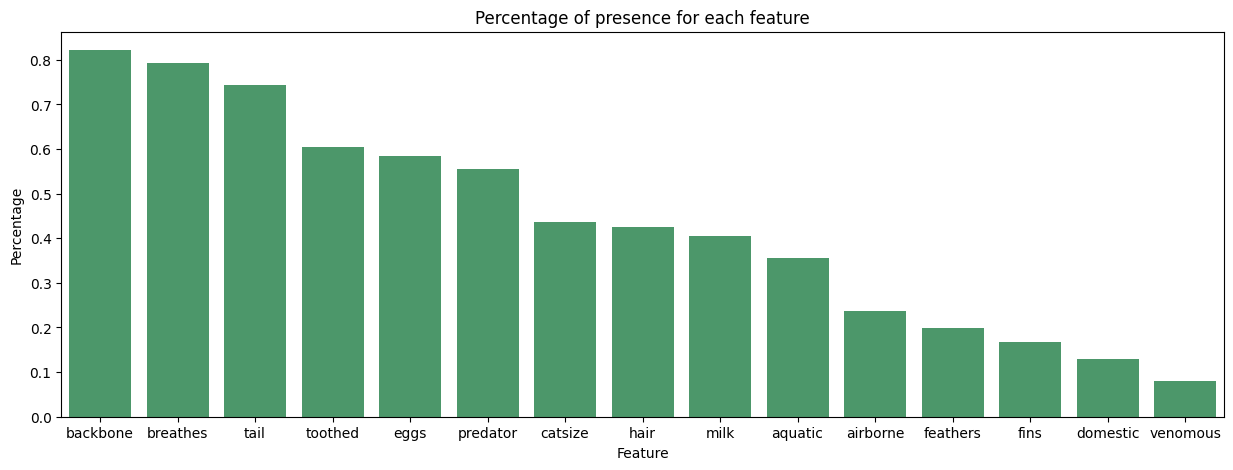

In [48]:
plt.figure( figsize = (15,5))

ax = sns.barplot(data = zoo.describe().loc['mean'].drop(non_boolean_features).sort_values(ascending = False),
                 color = sns.xkcd_rgb['greenish'])

ax.set_title('Percentage of presence for each feature')
ax.set_xlabel('Feature')
ax.set_ylabel('Percentage')

plt.show()

In [30]:
zoo[zoo['backbone'] != 1]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
13,clam,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7
14,crab,0,0,1,0,0,1,1,0,0,0,0,0,4,0,0,0,7
15,crayfish,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
24,flea,0,0,1,0,0,0,0,0,0,1,0,0,6,0,0,0,6
30,gnat,0,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
39,honeybee,1,0,1,0,1,0,0,0,0,1,1,0,6,0,1,0,6
40,housefly,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
42,ladybird,0,0,1,0,1,0,1,0,0,1,0,0,6,0,0,0,6
46,lobster,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
51,moth,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6


In [ ]:
zoo[zoo['backbone'] != 1].groupby('class_type').size()

class_type
6     8
7    10
dtype: int64

In [34]:
zoo[zoo['breathes'] != 1]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
12,chub,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
13,clam,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,7
14,crab,0,0,1,0,0,1,1,0,0,0,0,0,4,0,0,0,7
15,crayfish,0,0,1,0,0,1,1,0,0,0,0,0,6,0,0,0,7
18,dogfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,1,4
34,haddock,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,4
38,herring,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4


In [ ]:
zoo[zoo['breathes'] != 1].groupby('class_type').size()

class_type
3     1
4    13
7     7
dtype: int64

In [79]:
class_label.rename({'Class_Type': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class']

class_type
Mammal          41
Bird            20
Reptile          5
Fish            13
Amphibian        4
Bug              8
Invertebrate    10
Name: Number_Of_Animal_Species_In_Class, dtype: int64

- Refering to the last behaviour we noticed, there seems to be "unique" features for certain types of classes. For example, mammals (class 1) are the ones that only drink milk. Another example could be the presence of fins, which are mostly present in the fish class (number 4). The same thing with feathers and the bird class.  

- In general we see that many features have explainibility on the majority of classes.

In [92]:
pd.concat([zoo[list(boolean_features_w_class)].groupby('class_type').mean(),
           class_label.rename({'Class_Number': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class'].rename('size')], 
          axis = 1)

,breathes,aquatic,venomous,domestic,backbone,eggs,toothed,airborne,predator,catsize,tail,fins,milk,feathers,hair,size
class_type,,,,,,,,,,,,,,,,
1,1.0,0.146341,0.000000,0.195122,1.0,0.02439,0.97561,0.04878,0.536585,0.780488,0.853659,0.097561,1.0,0.0,0.95122,41
2,1.0,0.300000,0.000000,0.150000,1.0,1.00000,0.00000,0.80000,0.450000,0.300000,1.000000,0.000000,0.0,1.0,0.00000,20
3,0.8,0.200000,0.400000,0.000000,1.0,0.80000,0.80000,0.00000,0.800000,0.200000,1.000000,0.000000,0.0,0.0,0.00000,5
4,0.0,1.000000,0.076923,0.076923,1.0,1.00000,1.00000,0.00000,0.692308,0.307692,1.000000,1.000000,0.0,0.0,0.00000,13
5,1.0,1.000000,0.250000,0.000000,1.0,1.00000,1.00000,0.00000,0.750000,0.000000,0.250000,0.000000,0.0,0.0,0.00000,4
6,1.0,0.000000,0.250000,0.125000,0.0,1.00000,0.00000,0.75000,0.125000,0.000000,0.000000,0.000000,0.0,0.0,0.50000,8
7,0.3,0.600000,0.200000,0.000000,0.0,0.90000,0.00000,0.00000,0.800000,0.100000,0.100000,0.000000,0.0,0.0,0.00000,10


In [32]:
class_label

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


- The next heatmap could visualize better this situation.

In [95]:
gb = pd.concat([zoo[list(boolean_features_w_class)].groupby('class_type').mean(),
           class_label.rename({'Class_Number': 'class_type'}, axis = 1).set_index('class_type')['Number_Of_Animal_Species_In_Class'].rename('size')], 
          axis = 1)

dict_class_types = dict(zip(class_label['Class_Number'], class_label['Class_Type']))
gb.index = [dict_class_types[x] for x in gb.index]

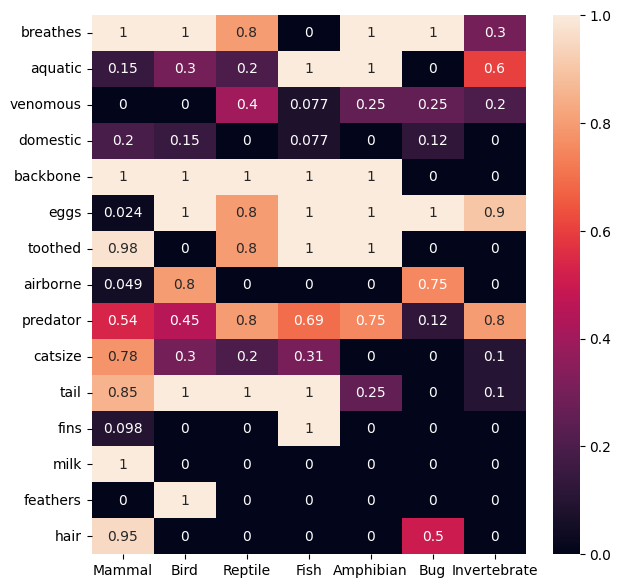

In [145]:
plt.figure(figsize = (7,7))

sns.heatmap(gb.drop('size', axis = 1).T, annot = True)

plt.show()

- Hey, but, what about the numbers of legs?

In [157]:
zoo['class_names'] = zoo['class_type'].replace(dict_class_types)

- We can say that mainly there's more animals between 0 and 4 legs, with some classes being more frequent in certain n° of legs.
- For example mammals (in this zoo), often have 4 legs, although is possible too to find them with 2 or even zero (less probable).
- All bugs have 6 legs, birds have 2 legs, and fishes have 0 legs. Also, reptiles are common with 0 and 4 legs. 
- Invertebrate animals are distributed between all nummber of legs.

- This, in combination with the other features, is very significant to identify the type of animal is present. Although, could our algorithm discover it by itself?

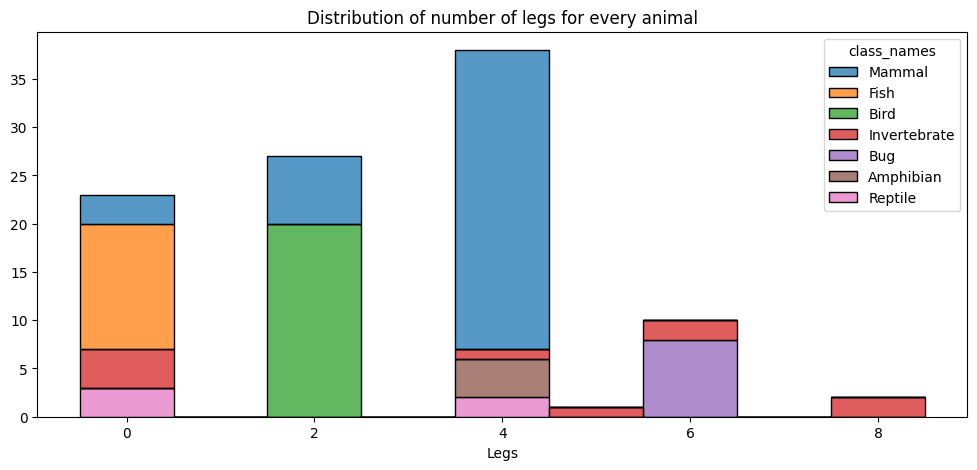

In [160]:
plt.figure(figsize = (12,5))

ax = sns.histplot(data = zoo, x ='legs' , 
                  hue ='class_names',
                  multiple = 'stack',
                  discrete = True)
ax.set_title('Distribution of number of legs for every animal')
ax.set_xlabel('Legs')
ax.set_ylabel('')

plt.show()

# Modeling